In [42]:
import os
import re
import numpy as np
import pandas as pd
from datetime import date, datetime
import calendar
from IPython.display import display,HTML
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

pd.set_option("display.max_colwidth", None)
pd.set_option("display.expand_frame_repr", False)
from DataProcessing import *
from RevenueReportHelpers import *

In [8]:
# Guesty bookiing records
# Exclusions + rename Ocean Spray 3 -> Cottage 3
data = import_data()
excl = {"Bellevue 4551","Bothell 21833","NorthBend 44406","Ashford 137","Auburn 29123","Hoquiam 21"}
data = data[~data["Listing"].isin(excl)].copy()
data = data[~((data["booking_source"]=="owner")|(data["accommodation_fare"]==0))].copy()
data.loc[data["Listing"].eq("Seattle 3617 Origin"), "Listing"] = "Seattle 3617"
data.loc[data["Listing"].eq("Seattle 906"), "Listing"] = "Seattle 906 Lower"
occupancy, daily = cal_occupancy(data)
property = property_input()

In [9]:
## Payout data : use pay time to merge with revenue, eg, payout in June for May revenue, 
#                2025 payout is for revenue 2024.12-2025.11
owner_payout_last, OwnerPayout_last = build_owner_payout_2425()
owner_payout_curr, OwnerPayout_curr = build_owner_payout_26(0)
owner_payout = pd.concat(
    [owner_payout_last, owner_payout_curr],
    ignore_index=True
)
owner_payout["Payout"] = pd.to_numeric(owner_payout["Payout"], errors="coerce")
#HTML(owner_payout.to_html())

In [10]:
monthly_STR =(data[data["Term"]=="STR"]
              .groupby(["Listing","yearmonth"],as_index=False)
              .agg(Revenue=("total_revenue","sum"))
              .merge(occupancy[["Listing","yearmonth","occdays","OccRt","Revenue_occ","Revenue_occ_accom","minADR","maxADR","avgADR","medADR"]],
                     on=["Listing","yearmonth"],how="outer")              
              )

monthly_STR["Revenue"].fillna(0)
monthly_STR["ADR"] = monthly_STR["Revenue_occ_accom"]/ monthly_STR["occdays"]

monthly_LTR = (daily[daily["Term"]=="LTR"]
               .groupby(["Listing","yearmonth"],as_index=False)
               .agg(occdays=("date", "count"),
                     Revenue_defer=("DailyListingPrice","sum"),
                     minADR = ("AvgDailyRate",'min'),
                     maxADR=("AvgDailyRate","max"),
                     avgADR = ("AvgDailyRate","mean"),
                     medADR = ("AvgDailyRate","median")
               ))
monthly_LTR["OccRt"] = monthly_LTR["occdays"] / monthly_LTR["yearmonth"].apply(days_in_month_from_yearmonth)

monthly = monthly_STR.merge(monthly_LTR,on=["Listing","yearmonth"],how="outer",suffixes=("","_LTR"))
monthly["Revenue"] = np.where(monthly["Revenue_defer"].isna(), monthly["Revenue"], monthly["Revenue_occ"])
monthly["Month"] = monthly["yearmonth"].str[5:7]
monthly["Year"] = monthly["yearmonth"].str[0:4]
monthly = monthly.merge(owner_payout[["Property","yearmonth","Payout"]], 
                        left_on=["Listing","yearmonth"], right_on=["Property","yearmonth"], how="left")
monthly = monthly.merge(property[["Listing","Type","Status"]],on="Listing",how='outer')

In [11]:
# select_listing = "Bellevue 1420"
# occupancy.loc[occupancy["Listing"]==select_listing,]
# daily.loc[(daily["Listing"]==select_listing) & (daily["yearmonth"].isin(["2026-01","2026-02"])),]
# print(monthly.loc[monthly["Listing"]==select_listing,["Listing","yearmonth","minADR","avgADR","medADR"]].sort_values(by="minADR").head())
# data.loc[(data["Listing"]==select_listing) &(data["checkin_date"]>=pd.to_datetime('2026-01-01')),
#         ["Listing","Confirmation.Code","checkin_date","nights","accommodation_fare","AvgDailyRate"]].sort_values(by="AvgDailyRate").head()

In [12]:
# Monthly tab pivot wide by Year for (Revenue, ADR, OccRt, Payout)
# 12/17: STR only, 

monthly_yrs = [
    yearrecords(monthly, str(k))   # ensure string
    for k in [2024, 2025, 2026]
]
# Normalize Month → int
for df in monthly_yrs:
    df["Month"] = df["Month"].astype(int)

# Build a complete 12-month grid for every listing that appears in any year
all_listings = pd.Index(
    pd.concat([df["Listing"] for df in monthly_yrs], ignore_index=True).unique(),
    name="Listing"
)
months = pd.Index(range(1, 13), name="Month")

base = (
    pd.MultiIndex.from_product([all_listings, months], names=["Listing", "Month"])
      .to_frame(index=False)
)

# Merge each year onto the full grid (keeps 12 rows per Listing)
monthly_tab = base
for df in monthly_yrs:
    monthly_tab = monthly_tab.merge(df, on=["Listing", "Month"], how="left")


# monthly_tab = monthly_yrs[0]
# for df in monthly_yrs[1:]:
#     monthly_tab = monthly_tab.merge(df, on=["Listing","Month"], how="outer")

    
monthly_tab = monthly_tab.sort_values(["Listing","Month"], kind="stable")
monthly_tab = safe_round(monthly_tab, ndigits=2)

monthly_tab,rev_incr25 =yoy_delta(monthly_tab, monthly, "2024", "2025")
monthly_tab,rev_incr26 =yoy_delta(monthly_tab,monthly, "2025", "2026")
monthly_tab = safe_round(monthly_tab, ndigits=2)
# monthly_tab = monthly_tab[["Listing","Month","Revenue_2024","ADR_2024","OccRt_2024",
#                            "Revenue_2025","ADR_2025","OccRt_2025","Rev_delta_2025","Rev_delta_2025_perc",
#                            "Revenue_2026","ADR_2026","OccRt_2026","Rev_delta_2026","Rev_delta_2026_perc"]]

rev_incr= pd.concat([rev_incr25,rev_incr26],ignore_index=True)

monthly = monthly.merge(rev_incr,on=["Listing","yearmonth"],how="left")

In [13]:
## Yearly summary pivot 
yearly = monthly.groupby(["Listing","Year"],as_index=False).agg(
    nights =("occdays","sum"),
    Revenue =("Revenue","sum"),
    ADR =("avgADR","mean")  # placeholder,
)

# 2/5/2026: Adjust Occ% according to first booking of the month
firstbooking = (daily
              .groupby(["Listing","Year"],as_index=False)
              .agg(firstbooking=("date","min")))
yearly = yearly.merge(firstbooking,on=["Listing","Year"],how='left')
yearly["firstbooking"] = pd.to_datetime(yearly["firstbooking"], errors="coerce")
yearly["days_to_eoy"] = (
    pd.to_datetime({"year": yearly["firstbooking"].dt.year,
        "month": 12,
        "day": 31})- yearly["firstbooking"]).dt.days + 1

yearly["OccRt"] = yearly["nights"] / yearly["days_to_eoy"] 
yearly = safe_round(yearly, ndigits=2)

tmp = pd.MultiIndex.from_product([["Revenue","ADR","OccRt"], [2024,2025,2026]]).tolist()
cols = [f"{m[0]}_{m[1]}" for m in tmp]

yearly_tab = yearly[yearly["Year"].isin(["2024","2025","2026"])].\
    pivot(index="Listing",  columns="Year",
          values=["Revenue","ADR","OccRt"]).reset_index()
yearly_tab.columns = ["Listing",*cols]


In [14]:
## Valta Occ rate : STR only, by region
mask =(data["total_revenue"]==48.5)&(data["yearmonth"].isin(["2024-10","2024-11"]))|\
    (data["Confirmation.Code"].isin(["HMBE2E392M","HMQAWPFBSZ","HM5ZZBP4NK"]))
 # remove testing rent)].copy()

data_adr = data[(~mask) & (data["checkin_date"]>=pd.to_datetime('2024-01-01'))& (data["checkin_date"]<=pd.to_datetime('2026-12-31'))].\
    merge(property[["Listing","Set","Type","Status"]],on="Listing",how="left")
data_str = data_adr.loc[(data_adr["Status"]=="Active") & (data_adr["Type"]=="STR") & (data_adr["nights"]<=31)].copy()
data_str["Year"]=data_str["checkin_date"].dt.strftime("%Y")
data_str["Month"]=data_str["checkin_date"].dt.strftime("%m")

occupancy_str,daily_str = cal_occupancy(data_str)
occ_valta = (occupancy_str.loc[occupancy_str["Year"].isin(["2024","2025","2026"]),["Listing","yearmonth","Year","Month","occdays","avgADR"]]
             .merge(property[["Listing","Market"]],on="Listing",how="left")
             .groupby(["yearmonth","Market"],as_index=False)
             .agg(listings = ("Listing","nunique"),
                  medocc=("occdays","median"),
                  avgocc=("occdays","mean"),
                  avgADR = ("avgADR","mean")))

#occ_valta["med_OccRt"] = occ_valta["medocc"] / occ_valta["yearmonth"].apply(days_in_month_from_yearmonth)
occ_valta["avg_OccRt"] = occ_valta["avgocc"] / occ_valta["yearmonth"].apply(days_in_month_from_yearmonth)
occ_valta = safe_round(occ_valta, ndigits=2)
occ_valta = occ_valta.sort_values(
    by=["Market", "yearmonth"],
    ascending=[True, True]
)
occ_valta = occ_valta[["yearmonth","Market","avg_OccRt","avgADR"]]
occ_valta["Year"] = occ_valta["yearmonth"].str[0:4]
#occ_valta.to_excel("/Users/ylin/Google Drive/My Drive/Data and Reporting/Valta_OccupancyRate.xlsx")

In [214]:
with pd.ExcelWriter( "/Users/ylin/Google Drive/My Drive/Data and Reporting/Valta_OccupancyRate.xlsx",
    engine="openpyxl" ) as ew:
    # Write dataframe
    occ_valta.to_excel(ew, sheet_name="Occupancy", index=False, na_rep="")
    # Get worksheet
    ws = ew.sheets["Occupancy"]

    # Freeze header row
    ws.freeze_panes = "A2"

    # Add AutoFilter to the used range
    ws.auto_filter.ref = ws.dimensions

In [215]:
# Add ADR range to yearly_tab
# yearly_tab = yearly_tab.merge(rangeADR,on="Listing",how="left")
# yearly_tab = safe_round(yearly_tab, ndigits=2)

In [15]:
## Only include the month till today 
#months_excl = range(3,13) #[11,12]
#lastdate = "-02-28"# today

today = date.today()

# last date of the current month (as string like "-02-28")
last_day = pd.Timestamp(today).days_in_month
lastdate = f"-{today.month:02d}-{last_day:02d}"

# remaining months in the current year
months_excl = range(today.month + 1, 13)
lastdays = [sum([monthrange(2024,m)[1] for m in months_excl]),
            sum([monthrange(2025,m)[1] for m in months_excl]),
            sum([monthrange(2026,m)[1] for m in months_excl])]
#lastdays =[0,0] # for 2025.12

yearly_todate = monthly.loc[monthly["Month"].isin([f"{x:02d}" for x in months_excl])==False].groupby(["Listing","Year"],as_index=False).agg(
    nights =("occdays","sum"),
    Revenue =("Revenue","sum"),
    ADR =("avgADR","mean")  # placeholder,
)
#yearly_todate["ADR"] = yearly_todate["ADR"] / yearly_todate["nights"]
yearly_todate["OccRt"] = yearly_todate["nights"] / yearly_todate["Year"].\
    apply(lambda y: 366 - lastdays[0] if int(y)%4==0 else 365 - lastdays[1])
yearly_todate = safe_round(yearly_todate, ndigits=2)
yearly_todate_tab = yearly_todate[yearly_todate["Year"].isin(["2024","2025","2026"])].\
    pivot(index="Listing",  columns="Year",
          values=["Revenue","ADR","OccRt"]).reset_index()
yearly_todate_tab.columns = ["Listing",*cols]
#yearly_todate_tab = combine_osbr_beachwood(yearly_todate_tab)
yearly_todate_tab = safe_round(yearly_todate_tab, ndigits=2)
yearly_todate_tab["Ratio_today"] = np.where(yearly_todate_tab["Revenue_2025"].isin([0, np.nan]),np.nan,
                                                    yearly_todate_tab["Revenue_2026"]/yearly_todate_tab["Revenue_2025"])
yearly_todate_tab["RevLoss_today"] = np.where(yearly_todate_tab["Ratio_today"]<0.95,"Loss","")

In [16]:
OwnerPayout = OwnerPayout_last.merge(OwnerPayout_curr,on="Listing",how="outer")
OwnerPayout.columns=["Listing","OwnerDist_2024","OwnerDist_2025","OwnerDist_2026"]
OwnerPayout = safe_round(OwnerPayout)
yearly_tab = yearly_tab.merge(yearly_todate_tab[["Listing","Revenue_2026","ADR_2026","OccRt_2026","Ratio_today","RevLoss_today"]],
        on="Listing",how="left",suffixes=["","_today"])
yearly_tab = yearly_tab.merge(OwnerPayout,on="Listing",how="left")
yearly_tab = property.loc[property["Status"]=="Active",["Listing","Type"]].\
    merge(yearly_tab,on="Listing")
yearly_tab["Ratio25"] = np.where(yearly_tab["Revenue_2024"].isin([0, np.nan]),np.nan,
                                                    yearly_tab["Revenue_2025"]/yearly_tab["Revenue_2024"])
yearly_tab["RevLoss25"] = np.where(yearly_tab["Ratio25"]<0.95,"Loss","")
yearly_tab["Delta25"] = yearly_tab["OwnerDist_2025"] / yearly_tab["Revenue_2025"] - yearly_tab["OwnerDist_2024"]  / yearly_tab["Revenue_2024"]
#HTML(OwnerPayout.to_html())

In [18]:
## Payout sheet creation
Payout = yearly_tab[["Listing","Revenue_2024","Revenue_2025","Revenue_2026","Revenue_2026_today"]].merge(
                              OwnerPayout,on="Listing",how="outer").merge(
                      property[["Property","Listing","Type","Status"]],on="Listing",how="left")
Payout = Payout[Payout["Status"]=="Active"]
#Payout = combine_osbr_beachwood(Payout)
num_col = Payout.select_dtypes(include=[np.number]).columns


Payout_tab = Payout.groupby(["Property"],as_index=False).agg({c:"sum" for c in num_col})
for c in num_col:
        Payout_tab[c] = Payout_tab[c].replace(0, np.nan)
Payout_tab = safe_round(Payout_tab)
Payout_tab["owner_pay_perc_last"]  = Payout_tab["OwnerDist_2025"]  / Payout_tab["Revenue_2025"]
#HTML(Payout_tab.to_html())
Payout_tab["owner_pay_perc_today"] = Payout_tab["OwnerDist_2026"] / Payout_tab["Revenue_2026_today"]
Payout_tab["Delta"] = Payout_tab["owner_pay_perc_today"] - Payout_tab["owner_pay_perc_last"]
Payout_tab["flag"] = np.where(
    Payout_tab["Delta"] < (-0.02),
    np.where(Payout_tab["Revenue_2026"] < Payout_tab["Revenue_2025"], "High", "Med"),"Low")
Payout_tab["Delta25"] = Payout_tab["OwnerDist_2025"] / Payout_tab["Revenue_2025"] - Payout_tab["OwnerDist_2024"]  / Payout_tab["Revenue_2024"]
Payout_tab["flag25"] = np.where(
    Payout_tab["Delta25"] < (-0.02),
    np.where(Payout_tab["Revenue_2025"] < Payout_tab["Revenue_2024"], "High", "Med"),"Low")

Payout_tab = safe_round(Payout_tab)
#set(property.loc[property["Status"]=="Active","Property"])-set(Payout_tab["Property"])
Payout_tab = property[["Property","Type"]].drop_duplicates(subset="Property").merge(Payout_tab,on="Property",how="right")
set(property.loc[property["Status"]=="Active","Property"])-set(Payout_tab["Property"])
#HTML(Payout_tab.to_html())

{'Elektra 1314',
 'Elektra 1514',
 'Elektra 510',
 'Elektra 609',
 'Elektra 909',
 'Seattle 11331',
 nan}

In [219]:
## Rating based on VA inputs on 9/28/2025
cur_path = "/Users/ylin/Google Drive/My Drive/Data and Reporting/Data/Revenue/Property_OverallRatings.xlsx"
current = pd.read_excel(cur_path)
num_cols = [c for c in current.columns if re.search(r"(Number|Overall)",c)]
for c in num_cols:
    current[c] = pd.to_numeric(current[c], errors="coerce")
current[num_cols] = current[num_cols].round(2)
current["Extract Date"] = pd.to_datetime(current["Extract Date"], errors="coerce", unit="d")
current[num_cols] = current[num_cols].fillna(0)
current["Nreview"] = 0
current["Current_weighted_rating"] = 0 # placeholder

def fmt_rating(val, n):
    return np.where(~np.isin(val, [0, np.nan]), val.round(2).astype(str) + " (" + n.astype("Int64").astype(str) + ")", np.nan)
   
for k in ["Airbnb","VRBO","Booking"]:
    ncol = f"Number of reviews {k}"
    ocol =f"Overall {k}"
    idx = (current[ncol].isin([0,np.nan])) | (current[ocol].isin([0,np.nan]) & current[ncol].notna())
    current.loc[idx,ocol] = 0
    current.loc[idx,ncol] = 0
    if k!="Airbnb":
        current[ocol] = current[ocol]/2
    current["Nreview"]=current["Nreview"]+current[ncol]
    current["Current_weighted_rating"] = current["Current_weighted_rating"] + \
            current[ncol]*current[ocol]
    current[f"Current_rating_{k}"] = fmt_rating(current[ocol],current[ncol])

current["Current_weighted_rating"] = current["Current_weighted_rating"]/current["Nreview"]

In [220]:
 # Ratings pulled from Guesty + canceled bookings to enrich
ratings_path = "/Users/ylin/Google Drive/My Drive/** Properties ** -- Valta/0_Cohosting/1-Reviews/Guesty reviews from Tech team/20260116 guesty_reviews.xlsx"
ratings = pd.read_excel(ratings_path)

canceled = pd.read_csv("/Users/ylin/Google Drive/My Drive/Data and Reporting/Data/Revenue/GuestyCanceled.csv", na_values=["", " "])
col=canceled.columns
col =[re.sub(" |-|'",'.',c) for c in col]
canceled.columns = col
for col in ["NUMBER.OF.ADULTS","NUMBER.OF.CHILDREN","NUMBER.OF.INFANTS","PET.FEE"]:
    canceled[col] = np.nan
platforms = pd.read_excel("/Users/ylin/Google Drive/My Drive/Data and Reporting/Data/Revenue/Source_Platform.xlsx")
canceled = canceled.merge(platforms, on="SOURCE", how="left")
canceled_fmt = format_reservation(canceled, "2017-01-01", "2025-12-31")
canceled_fmt["status"] = "canceled"
canceled_fmt["Term"] = "STR"
guestydata = data.copy()
guestydata['status'] = 'confirmed' 
guestydata = pd.concat([guestydata,canceled_fmt],ignore_index=True,sort=False)
ratings = ratings.merge(guestydata[["Listing","Confirmation.Code","status",'checkin_date','checkout_date','booking_platform']],
                         left_on="Reservation",right_on="Confirmation.Code",how='left')
ratings["createdAt"] = pd.to_datetime(ratings["createdAt"],errors="coerce")

# New ratings since 2025-09-28 → incremental averages per platform    
ratings_add = (ratings[ratings["createdAt"] > pd.Timestamp("2025-09-28")]
              .groupby(["Listing","booking_platform"],as_index=False)
              .agg(number=("Overall","count"),Overall=("Overall","mean"))
              .pivot(index="Listing",columns="booking_platform",values=["number","Overall"])
              .reset_index())
ratings_add.columns = ["_".join([c for c in col if c]).strip("_") for col in ratings_add.columns.to_flat_index()]
ratings_add["Overall_Booking"] = ratings_add["Overall_Booking.com"] / 2.0
ratings_add["number_Booking"] = ratings_add["number_Booking.com"]
cur_upd = current.merge(ratings_add, on ="Listing",how="outer")

cur_upd["Current_weighted_rating"] = cur_upd["Current_weighted_rating"] * cur_upd["Nreview"]
for k in ["Airbnb","VRBO","Booking"]:
    ncol = cur_upd[f"Number of reviews {k}"].fillna(0)
    ocol =cur_upd[f"Overall {k}"].fillna(0)
    ncol1 = cur_upd[f"number_{k}"].fillna(0)
    ocol1 = cur_upd[f"Overall_{k}"].fillna(0)
    num = (ncol*ocol)+(ncol1*ocol1)
    den = ncol+ncol1
    with np.errstate(divide="ignore", invalid="ignore"):
        cur_upd[f"Overall_{k}"] =  fmt_rating(num/den,den) 
    cur_upd["Nreview"] = cur_upd["Nreview"].fillna(0) + ncol1.fillna(0)
    cur_upd["Current_weighted_rating"] = cur_upd["Current_weighted_rating"].fillna(0) + (ncol1*ocol1)

cur_upd["Current_weighted_rating"] = cur_upd["Current_weighted_rating"]/cur_upd["Nreview"]
cur_upd = safe_round(cur_upd)

In [221]:
ratings["checkin_date"] = pd.to_datetime(ratings.get("checkin_date"), errors="coerce")
ratings_sum_yr = (
    ratings.assign(year=lambda d: d["checkin_date"].dt.year, month=lambda d: d["checkin_date"].dt.month,
                   score = np.where(ratings["booking_platform"]=="Booking.com", ratings["Overall"]/2, ratings["Overall"]))
    .query("year >= 2024")
    .groupby(["Listing","year","booking_platform"], as_index=False)
    .agg(reviews=("Overall","count"), overall=("Overall","mean"))
    .assign(Rating_reviews=lambda d: d["overall"].round(2).astype(str) + " (" + d["reviews"].astype(str) + ")")
    .pivot(index="Listing", columns=["year","booking_platform"], values="Rating_reviews")
    .reset_index()
)
ratings_sum_yr.columns = ["_".join([str(c) for c in col if c]).strip("_") for col in ratings_sum_yr.columns.to_flat_index()]

In [222]:
ratings_all=(ratings
             .assign(year=lambda d: d["checkin_date"].dt.year, 
                     month=lambda d: d["checkin_date"].dt.month,
                     score = np.where(ratings["booking_platform"]=="Booking.com", ratings["Overall"]/2, ratings["Overall"]))
            .query("year >= 2024")
            .groupby(["Listing","year","booking_platform"], as_index=False)
            .agg(reviews=("Overall","count"), score=("score","sum"))
            .groupby(["Listing","year"], as_index=False)
            .agg(reviews=("reviews","sum"), yearly_rating=("score","sum")))
ratings_all = ratings_all.assign(rating = lambda d: d["yearly_rating"] / d["reviews"])
ratings_all =(ratings_all.pivot(index="Listing", columns=["year"], values=["rating","reviews"]) .reset_index())
ratings_all.columns = ratings_all.columns = (
    ["Listing"]
    + [
        f"{metric}_{int(year)}"
        for metric, year in ratings_all.columns[1:]
    ]
)
ratings_sum_yr = ratings_sum_yr.merge(ratings_all, on="Listing", how="left")

In [223]:
 # Merge ratings onto yearly_tab & flagging (as in R)
yearly_tab = yearly_tab.merge(ratings_sum_yr, on="Listing", how="left").merge(
    cur_upd[["Listing","Current_weighted_rating","Nreview","Current_rating_Airbnb","Current_rating_VRBO","Current_rating_Booking"]],
    on="Listing", how="left"
)
# Flag logic
# If Type == LTR => flag NA; else:
#   if Revenue_hlt_today == "Loss": High if rating<4.8 else Med
#   else Low if rating<4.8 else NA

def compute_flag(row,RatioCol):
    if row.get("Type") == "LTR":
        return np.nan
    loss = (row.get(RatioCol) == "Loss")
    rating = row.get("Current_weighted_rating")
    if (row.get(RatioCol) == "Loss"):
        return "High" if (pd.notna(rating) and rating < 4.8) else "Med"
    else: 
        return "Low" if (pd.notna(rating) and rating < 4.8) else np.nan

yearly_tab["flag"] = yearly_tab.apply(compute_flag, RatioCol="RevLoss_today",axis=1)
yearly_tab["flag25"] = yearly_tab.apply(compute_flag, RatioCol="RevLoss25",axis=1)

years_cols = ['Listing', 'Type', 'Revenue_2024', 'ADR_2024','OccRt_2024',
                'Revenue_2025', 'ADR_2025', 'OccRt_2025', "Ratio25","flag25","RevLoss25",
                'Revenue_2026', 'Revenue_2026_today','ADR_2026_today', 'OccRt_2026_today', 
                'Ratio_today','flag','RevLoss_today',
                '2024.0_Airbnb', '2024.0_Booking.com', '2024.0_VRBO', '2025.0_Airbnb',
                '2025.0_Booking.com', '2025.0_VRBO', 'Current_weighted_rating',
                'Current_rating_Airbnb', 'Current_rating_VRBO','Current_rating_Booking','Nreview', 
                "rating_2024","rating_2025","rating_2026","reviews_2024","reviews_2025","reviews_2026",
                'OwnerDist_2024', 'OwnerDist_2025','OwnerDist_2026','ADR_2026', 'OccRt_2026']

yearly_tab = yearly_tab[years_cols]
payout_cols =['Property', 'Type', 'Revenue_2024', 'OwnerDist_2024',
               'Revenue_2025', 'OwnerDist_2025','Revenue_2026','Revenue_2026_today', 'OwnerDist_2026',
                'owner_pay_perc_last', 'owner_pay_perc_today', 'Delta', 'flag']
Payout_tab = Payout_tab[payout_cols]

In [ ]:
month_map = {
        "Jan": "01", "Feb": "02", "Mar": "03", "Apr": "04",
        "May": "05", "Jun": "06", "Jul": "07", "Aug": "08",
        "Sept": "09", "Sep": "09", "Oct": "10", "Nov": "11", "Dec": "12"
    }
def transfer_marketdata(df,market_sel):
    long = (
        df.melt(
            id_vars="Category",
            var_name="Year",
            value_name="Value"
        )
        .dropna(subset=["Value"])
    )

    long["Month"] = long["Category"].map(month_map)
    long["yearmonth"] = long["Year"].astype(str) + "-" + long["Month"]
    final_long = long[["yearmonth", "Value"]].sort_values("yearmonth").reset_index(drop=True)
    final_long["Market"] = market_sel
    return final_long

def collect_marketsets(file_name,metric_name,curr_date,property,year_sel="2026"):
    market_all = []
    for k in sorted(property.loc[property["Type"] == "STR", "Market"].dropna().unique()):
        high = pd.read_csv("/Users/ylin/Google Drive/My Drive/Data and Reporting/Data/Revenue/MarketData/"+curr_date+"/"+k+file_name+".csv")
        tmp = transfer_marketdata(high,k)
        market_all.append(tmp)
    
    market_all = pd.DataFrame(pd.concat(market_all, ignore_index=True))
    market_all = market_all.rename(columns={"Value":metric_name})
    market_all = market_all[market_all["yearmonth"].str.startswith(year_sel)]
    if "ADR" not in metric_name:
        market_all[metric_name] = market_all[metric_name]/100
    return market_all.copy()

curr_date = f"{today.year:04d}{today.month:02d}{today.day:02d}"
#df = pd.read_excel("/Users/ylin/Google Drive/My Drive/Data and Reporting/Data/Revenue/MarketData/"+curr_date+"/Market Data.xlsx")
#df = df[df["Varname"]=="Adj. Occupancy"]
# market_all = (
#         df.drop(columns=["Varname"])
#         .melt(
#             id_vars="Market",
#             var_name="yearmonth",
#             value_name="Occ_All"
#         )
#         .dropna(subset=["Occ_All"])
#     )

occ_all = collect_marketsets("","Occ_All",curr_date,property)
occ_hp = collect_marketsets("_high","Occ_HP",curr_date,property)
adr_all = collect_marketsets(" ADR","ADR_All",curr_date,property)
adr_hp = collect_marketsets(" ADR_high","ADR_HP",curr_date,property)

market_all = (occ_all
              .merge(occ_hp,on=["Market","yearmonth"],how="outer")
              .merge(adr_all,on=["Market","yearmonth"],how="outer")
              .merge(adr_hp,on=["Market","yearmonth"],how="outer"))
#market202601["Occ_All"] = pd.to_numeric(market202601["Occ_All"], errors="coerce")


In [ ]:
# occ_all = collect_marketsets("","Occ_All",curr_date,property,"2025")
# occ_hp = collect_marketsets("_high","Occ_HP",curr_date,property,"2025")
# adr_all = collect_marketsets(" ADR","ADR_All",curr_date,property,"2025")
# adr_hp = collect_marketsets(" ADR_high","ADR_HP",curr_date,property,"2025")

# market_2025 = (occ_all
#               .merge(occ_hp,on=["Market","yearmonth"],how="outer")
#               .merge(adr_all,on=["Market","yearmonth"],how="outer")
#               .merge(adr_hp,on=["Market","yearmonth"],how="outer"))

# df=market_2025.merge(occ_valta,on=["Market","yearmonth"],how="inner")
# df["Month"] = df["yearmonth"].str[5:7]
# #df.to_excel("/Users/ylin/Google Drive/My Drive/Data and Reporting/Valta_MarketData_2025.xlsx", index=False)
# df


,yearmonth,Occ_All,Market,Occ_HP,ADR_All,ADR_HP,avg_OccRt,avgADR,Year,Month
0,2025-01,0.234194,Aberdeen,0.350516,247.032258,342.032258,0.34,73.23,2025,01
1,2025-02,0.274321,Aberdeen,0.395143,260.500000,362.285714,0.34,76.96,2025,02
2,2025-03,0.302645,Aberdeen,0.389387,268.225806,379.548387,0.39,95.63,2025,03
3,2025-04,0.404967,Aberdeen,0.573200,296.533333,410.333333,0.51,97.00,2025,04
4,2025-05,0.331000,Aberdeen,0.411806,289.387097,408.225806,0.46,100.39,2025,05
...,...,...,...,...,...,...,...,...,...,...
67,2025-08,0.627645,Seattle,0.794806,290.548387,360.709677,0.67,264.88,2025,08
68,2025-09,0.525833,Seattle,0.658700,251.400000,306.133333,0.55,217.22,2025,09
69,2025-10,0.430355,Seattle,0.564097,222.032258,265.000000,0.66,164.42,2025,10
70,2025-11,0.311100,Seattle,0.419633,210.400000,245.266667,0.43,167.94,2025,11


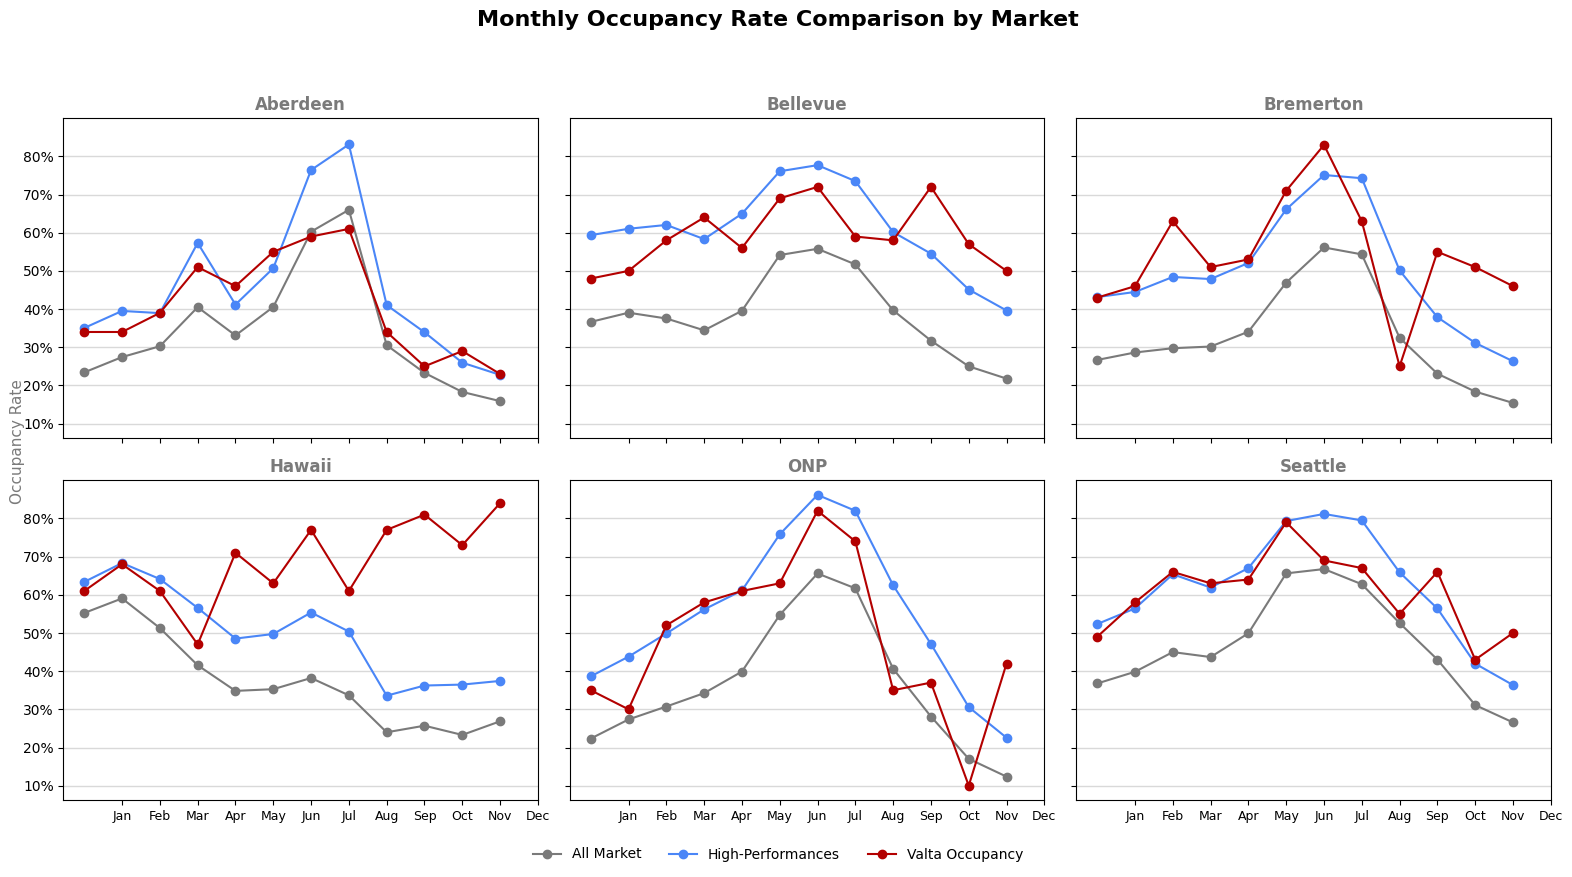

<Figure size 640x480 with 0 Axes>

In [ ]:
# VALTA_BLUE = "#4A86F7"   # primary bars / lines
# VALTA_RED  = "#B30000"   # accents, callouts, footer themes
# TEXT_GRAY  = "#7A7A7A"
# GRID_GRAY  = "#D9D9D9"
# month_labels = [calendar.month_abbr[m] for m in range(1, 13)]
# markets = sorted(df["Market"].dropna().unique())
# n = len(markets)
# ncols = 3
# nrows = 2

# fig, axes = plt.subplots(nrows, ncols, figsize=(16, 9), sharex=True, sharey=True)
# axes = axes.flatten()

# for i, mkt in enumerate(markets):
#     ax = axes[i]
#     df_sel = df[df["Market"] == mkt].copy().sort_values("Month")

#     ax.plot(df_sel["Month"], df_sel["Occ_All"], marker="o", color=TEXT_GRAY,label="All Market")
#     ax.plot(df_sel["Month"], df_sel["Occ_HP"], marker="o", color=VALTA_BLUE,label="High-Performances")
#     ax.plot(df_sel["Month"], df_sel["avg_OccRt"], marker="o", color=VALTA_RED,label="Valta Occupancy")
    
#     ax.set_title(str(mkt), fontsize=12, weight="bold", color=TEXT_GRAY)
#     ax.grid(axis="y", color=GRID_GRAY, linewidth=1)
#     ax.grid(axis="x", visible=False)
#     ax.set_xticks(range(1, 13))
#     ax.set_xticklabels(month_labels, fontsize=9)

# # Hide any unused panels (if markets < grid slots)
# for j in range(i + 1, len(axes)):
#     axes[j].axis("off")

# # Percent axis formatting (0–1)
# for ax in axes[:n]:
#     ax.yaxis.set_major_formatter(PercentFormatter(1.0))

# # Global labels
# fig.suptitle("Monthly Occupancy Rate Comparison by Market", fontsize=16, weight="bold")
# #fig.supxlabel("Month", fontsize=11, color=TEXT_GRAY)
# fig.supylabel("Occupancy Rate", fontsize=11, color=TEXT_GRAY)

# # One legend for the whole page
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False, bbox_to_anchor=(0.5, 0.02))

# plt.tight_layout(rect=[0, 0.06, 1, 0.94])
# plt.show()

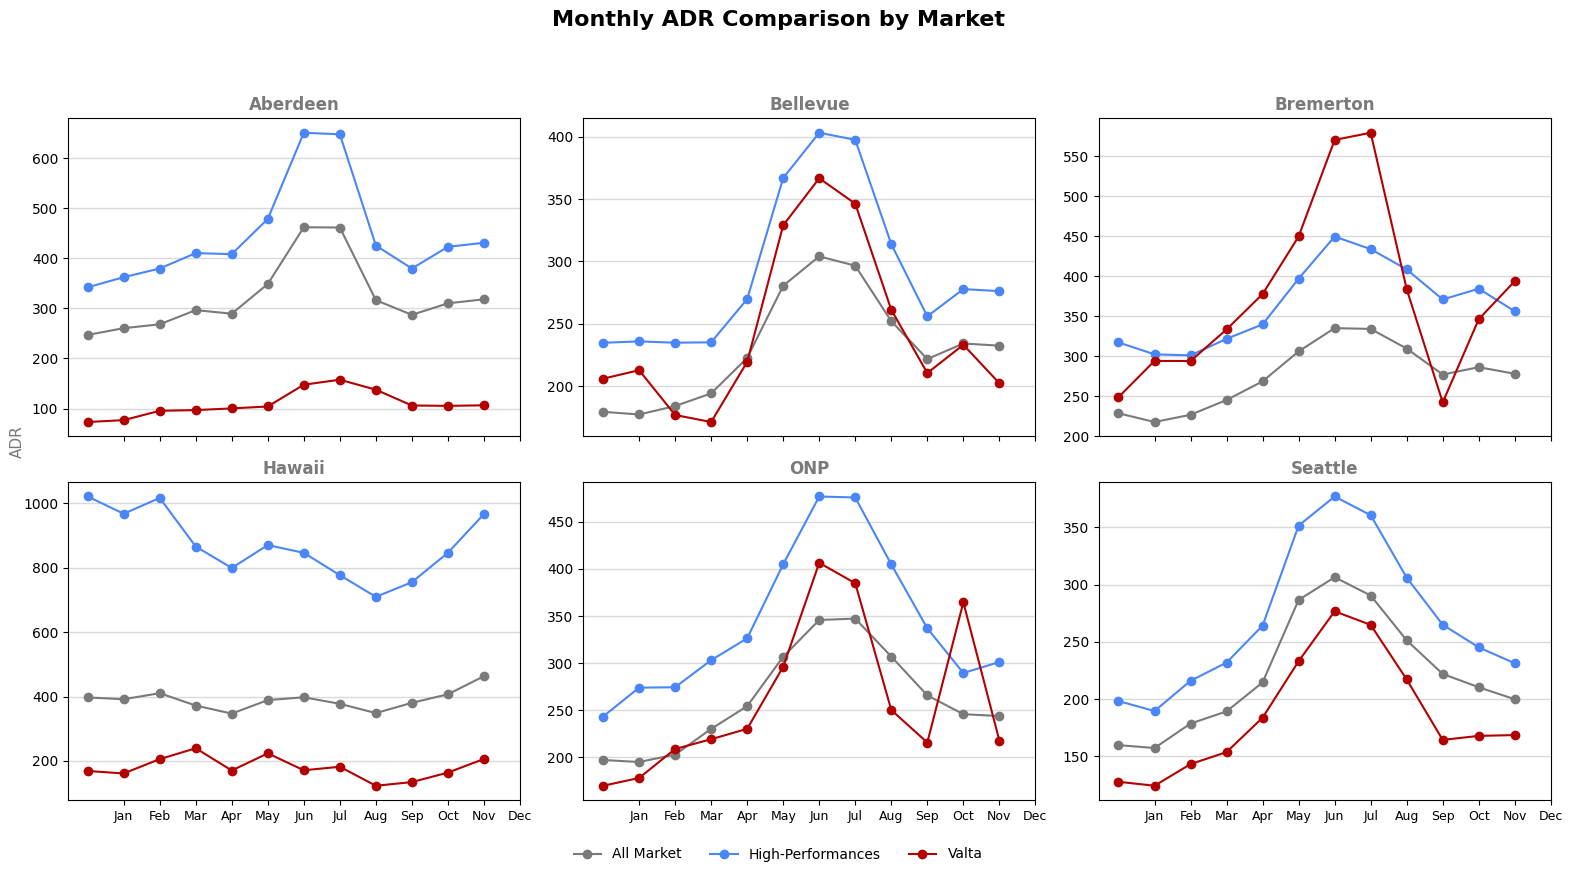

In [ ]:
# fig, axes = plt.subplots(nrows, ncols, figsize=(16, 9), sharex=True, sharey=False)
# axes = axes.flatten()
# for i, mkt in enumerate(markets):
#     ax = axes[i]
#     df_sel = df[df["Market"] == mkt].copy().sort_values("Month")

#     ax.plot(df_sel["Month"], df_sel["ADR_All"], marker="o", color=TEXT_GRAY,label="All Market")
#     ax.plot(df_sel["Month"], df_sel["ADR_HP"], marker="o", color=VALTA_BLUE,label="High-Performances")
#     ax.plot(df_sel["Month"], df_sel["avgADR"], marker="o", color=VALTA_RED,label="Valta")
    
#     ax.set_title(str(mkt), fontsize=12, weight="bold", color=TEXT_GRAY)
#     ax.grid(axis="y", color=GRID_GRAY, linewidth=1)
#     ax.grid(axis="x", visible=False)
#     ax.set_xticks(range(1, 13))
#     ax.set_xticklabels(month_labels, fontsize=9)

# # Hide any unused panels (if markets < grid slots)
# for j in range(i + 1, len(axes)):
#     axes[j].axis("off")

# # Global labels
# fig.suptitle("Monthly ADR Comparison by Market", fontsize=16, weight="bold")
# #fig.supxlabel("Month", fontsize=11, color=TEXT_GRAY)
# fig.supylabel("ADR", fontsize=11, color=TEXT_GRAY)

# # One legend for the whole page
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False, bbox_to_anchor=(0.5, 0.02))

# plt.tight_layout(rect=[0, 0.06, 1, 0.94])
# plt.show()

In [226]:
market_today = (market_all.assign(Month=market_all["yearmonth"].str[-2:]))
market_today = market_today[market_today["Month"].isin([f"{x:02d}" for x in months_excl])==False]
market_today = (market_today
                .assign(DaysInMonth=market_today["yearmonth"].apply(days_in_month_from_yearmonth)))

market_today = (market_today
                .assign(Occ_All_today = market_today["Occ_All"]*market_today["DaysInMonth"],
                        Occ_HP_today = market_today["Occ_HP"]*market_today["DaysInMonth"],
                        ADR_All_today = market_today["ADR_All"]*market_today["DaysInMonth"],
                        ADR_HP_today = market_today["ADR_HP"]*market_today["DaysInMonth"])
                )
market_today = market_today.groupby("Market",as_index=False).agg(
    Occ_All_today = ("Occ_All_today","sum"),
    Occ_HP_today = ("Occ_HP_today","sum"),
    ADR_All_today = ("ADR_All_today","sum"),
    ADR_HP_today = ("ADR_HP_today","sum"),
    Days = ("DaysInMonth","sum")
)
cols = ["Occ_All_today", "Occ_HP_today", "ADR_All_today", "ADR_HP_today"]

market_today[cols] = market_today[cols].div(market_today["Days"], axis=0)
market_today = safe_round(market_today)

In [227]:
## Add 2026.01 market data to yearly report
yearly_tab = (yearly_tab
              .merge(property[["Listing","Market"]],on="Listing",how="left")
              .merge(market_today,on="Market",how='left'))
yearly_tab["PerformanceFlag"] = np.where(yearly_tab["OccRt_2026_today"].isna(),None,
                                         np.where(yearly_tab["OccRt_2026_today"]<yearly_tab["Occ_All_today"],"< Market Occ",
                                            np.where(yearly_tab["OccRt_2026_today"]>yearly_tab["Occ_HP_today"],"> HP Occ","Middle")))

In [228]:
## Add 2025.02-12 and 20226.01 market data to monthly report
#market_period = [f"2025-{m:02d}" for m in range(2, 13)]
#market_m = market202601[market202601["Year"]=="2026"]#["yearmonth"].isin(["2026-01",*market_period])]
market_m = market_all.copy()
market_m = market_m.assign(Month=market_all["yearmonth"].str[5:].astype(int))

monthly_tab  = (monthly_tab
            .merge(property[["Listing","Market"]],on="Listing",how="left")
            .merge(market_m.drop(columns="yearmonth"),on=["Market","Month"],how="left"))
monthly_tab["PerformanceFlag"] = np.where(monthly_tab["OccRt_2026"].isna(),None,
                                    np.where(monthly_tab["OccRt_2026"]<monthly_tab["Occ_All"],"< Market Occ",
                                        np.where(monthly_tab["OccRt_2026"]>monthly_tab["Occ_HP"],"> HP Occ","Middle")))

In [229]:
# Output
out = {
    "yearly": yearly_tab.loc[yearly_tab["Type"]=="STR"],         # includes ratings & flags above
    "payout": Payout_tab.loc[Payout_tab["Type"]=="STR"],
    "monthly": monthly_tab,
    "monthly_long": monthly.assign(Year=lambda d: pd.to_numeric(d["Year"],errors="coerce").astype("Int64"),
                                            Month=lambda d: pd.to_numeric(d["Month"],errors="coerce").astype("Int64")),
   #"Ranges": Ranges,
}

In [230]:
FORMAT_RULES = {
    "currency": {
        "pattern": r"(Revenue|Payout|OwnerDist|ADR|Profit|Cost|Fee)",
        "excel_format": "$#,##0"
    },
    "percent": {
        "pattern": r"(OccRt|Ratio|RevLoss|Pct|Occ_All|Occ_HP)",
        "excel_format": "0%"
    }
}

In [231]:
from openpyxl.utils import get_column_letter
with pd.ExcelWriter("/Users/ylin/Google Drive/My Drive/Data and Reporting/RevenueReport_upd.xlsx", engine="openpyxl") as ew:
     for sheet_name, df in out.items():
        sheet = sheet_name[:31]
        df.to_excel(ew, sheet_name=sheet, index=False, na_rep="")

        ws = ew.sheets[sheet]
        
        # Freeze header row (row 1)
        ws.freeze_panes = "A2"

        # Add AutoFilter to the used range
        ws.auto_filter.ref = ws.dimensions

        # Identify which columns match which format
        for rule in FORMAT_RULES.values():
            pattern = re.compile(rule["pattern"], flags=re.IGNORECASE)
            fmt = rule["excel_format"]

            match_cols = [j for j, c in enumerate(df.columns, start=1) if pattern.search(str(c))]
            for col_idx in match_cols:
                col_letter = get_column_letter(col_idx)

                # Apply number format to all data rows (skip header row 1)
                for row in range(2, ws.max_row + 1):
                    cell = ws[f"{col_letter}{row}"]
                    if cell.value is None or cell.value == "":
                        continue
                    cell.number_format = fmt

                # Optional: set column width
                ws.column_dimensions[col_letter].width = 14            